In the previous step, we have determined the best approach to imputing missing features. In this stage, we focus on improving the quality of our XGBoost model, trained on labelled data, in isolation. In parallel we may seek to optimise other models, such as DNN, and later aggregate these models.

**Constants:**
* Feature selection, preprocessing of tabular data
* Missing feature imputation approach, as determined previously
* Using labelled data only
* Using XGBoost model only

**Varying:**
* Including or not including actigraph data
* PCA on included features
* Augmenting vs not augmenting data
* XGBoost model parameters
* Using sample weights based on number of features imputed
* Evaluation function: negative mean squared error or QWK on binned target
* Targeting PCIAT-PCIAT_Total, binned PCIAT or sii


In [1]:
import numpy as np
import pandas as pd

import os

import polars as pl
from glob import glob
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.svm import SVR

import lightgbm as lgb

from sklearn.model_selection import KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

import matplotlib.pyplot as plt

# Set up features and impute as determined previously

In [2]:
train_data=pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

In [3]:
INPUT_DIR = "/kaggle/input/child-mind-institute-problematic-internet-use/"

# Import aggregate fields from parquet files
# Modified code from rsakata: https://www.kaggle.com/code/rsakata/cmi-piu-16th-place-solution

files_train = glob(INPUT_DIR + "series_train.parquet/*")
#if IS_SUBMIT:
#    files += glob(INPUT_DIR + "series_test.parquet/*")

list_df_train = []
for file in tqdm(files_train):
    df_series = (
        pl.read_parquet(file)
        .with_columns(
            (
                (pl.col("relative_date_PCIAT") - pl.col("relative_date_PCIAT").min())*24
                + (pl.col("time_of_day") // int(1e9)) / 3600
            ).floor().cast(int).alias("total_hours")
        )
        .filter(pl.col("non-wear_flag") != 1)
        .filter(pl.col("step").count().over("total_hours") == 12 * 60)
        .group_by("total_hours").agg(
            pl.col("enmo").std().alias("enmo_std"),
            pl.col("anglez").std().alias("anglez_std"),
            pl.col("light").std().alias("light_std")
        )
        .with_columns(
            (pl.col("total_hours") % 24).alias("hour"),
            pl.lit(file.split("/")[-1][3:]).alias("id")
        )
    )
    list_df_train.append(df_series.to_pandas())

df_series = pd.concat(list_df_train)
df_series["enmo_std"] = np.log(df_series["enmo_std"] + 0.01)
df_series["anglez_std"] = np.log(df_series["anglez_std"] + 1)
df_series["light_std"] = np.log(df_series["light_std"] + 0.01)

df_agg_train = df_series.groupby("id")[["enmo_std", "anglez_std", "light_std"]].agg(["mean", "std"]).reset_index()
df_agg_train.columns = [cols[0] + "_" + cols[1] if cols[1] != "" else cols[0] for cols in df_agg_train.columns]
df_agg_train

  0%|          | 0/996 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00115b9f,-4.000377,NaN,1.989905,NaN,0.051475,NaN
1,001f3379,-3.514671,0.652348,3.236993,0.678888,0.774591,2.945807
2,00f332d1,-3.071176,0.927238,3.249122,0.463244,1.138379,2.939823
3,01085eb3,-2.902040,0.791255,3.389762,0.315061,1.054698,2.185839
4,012cadd8,-2.806918,1.171675,3.337322,0.388409,0.823770,3.350365
...,...,...,...,...,...,...,...
964,fe9c71d8,-3.116904,0.961804,3.037607,0.943554,-0.394200,2.742634
965,fecc07d6,-3.969482,0.981531,1.332831,1.428363,-0.438018,1.795653
966,ff18b749,-2.820076,0.937540,3.258458,0.417267,1.236652,3.341580
967,ffcd4dbd,-3.271800,0.827489,3.183395,0.629553,0.521227,2.665325


In [4]:
train_data2 = train_data.merge(df_agg_train, how="left", on="id")
train_data2.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,54.0,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.0,Winter,0.0,1.0,-4.000377,NaN,1.989905,NaN,0.051475,NaN
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
files_test = glob(INPUT_DIR + "series_test.parquet/*")


list_df_test = []
for file in tqdm(files_test):
    df_series = (
        pl.read_parquet(file)
        .with_columns(
            (
                (pl.col("relative_date_PCIAT") - pl.col("relative_date_PCIAT").min())*24
                + (pl.col("time_of_day") // int(1e9)) / 3600
            ).floor().cast(int).alias("total_hours")
        )
        .filter(pl.col("non-wear_flag") != 1)
        .filter(pl.col("step").count().over("total_hours") == 12 * 60)
        .group_by("total_hours").agg(
            pl.col("enmo").std().alias("enmo_std"),
            pl.col("anglez").std().alias("anglez_std"),
            pl.col("light").std().alias("light_std")
        )
        .with_columns(
            (pl.col("total_hours") % 24).alias("hour"),
            pl.lit(file.split("/")[-1][3:]).alias("id")
        )
    )
    list_df_test.append(df_series.to_pandas())

df_series = pd.concat(list_df_test)
df_series["enmo_std"] = np.log(df_series["enmo_std"] + 0.01)
df_series["anglez_std"] = np.log(df_series["anglez_std"] + 1)
df_series["light_std"] = np.log(df_series["light_std"] + 0.01)

df_agg_test = df_series.groupby("id")[["enmo_std", "anglez_std", "light_std"]].agg(["mean", "std"]).reset_index()
df_agg_test.columns = [cols[0] + "_" + cols[1] if cols[1] != "" else cols[0] for cols in df_agg_test.columns]
df_agg_test

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00115b9f,-4.000377,NaN,1.989905,NaN,0.051475,NaN
1,001f3379,-3.514671,0.652348,3.236993,0.678888,0.774591,2.945807


In [6]:
test_data2 = test_data.merge(df_agg_test, how="left", on="id")
test_data2.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,Fall,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,46.0,64.0,Summer,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,38.0,54.0,Summer,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,31.0,45.0,Winter,0.0,-4.000377,NaN,1.989905,NaN,0.051475,NaN
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
X_train = train_data2[['Basic_Demos-Age',
                      'Basic_Demos-Sex',
                      'CGAS-CGAS_Score',
                      'Physical-BMI',
                      'BIA-BIA_BMI',
                      'Physical-Waist_Circumference',
                      'Physical-Diastolic_BP',
                      'Physical-HeartRate',
                      'Physical-Systolic_BP',
                      'Fitness_Endurance-Max_Stage',
                      'Fitness_Endurance-Time_Mins',
                      'Fitness_Endurance-Time_Sec',
                      'FGC-FGC_CU_Zone',
                      'FGC-FGC_GSND_Zone',
                      'FGC-FGC_GSD_Zone',
                      'FGC-FGC_PU_Zone',
                      'FGC-FGC_SRL_Zone',
                      'FGC-FGC_SRR_Zone',
                      'FGC-FGC_TL_Zone',
                      'BIA-BIA_Activity_Level_num',
                      'BIA-BIA_BMC',
                      'BIA-BIA_BMR',
                      'BIA-BIA_DEE',
                      'BIA-BIA_ECW',
                      'BIA-BIA_FFM',
                      'BIA-BIA_FFMI',
                      'BIA-BIA_FMI',
                      'BIA-BIA_Fat',
                      'BIA-BIA_ICW',
                      'BIA-BIA_LDM',
                      'BIA-BIA_LST',
                      'BIA-BIA_SMM',
                      'BIA-BIA_TBW',
                      'PAQ_A-PAQ_A_Total',
                      'PAQ_C-PAQ_C_Total',
                      'SDS-SDS_Total_T',
                      'PreInt_EduHx-computerinternet_hoursday'
                       ,
                      'enmo_std_mean',
                      'enmo_std_std',
                      'anglez_std_mean',
                      'anglez_std_std',
                      'light_std_mean',
                      'light_std_std'
                      ]]

y_train = train_data2['PCIAT-PCIAT_Total']

X_test = test_data2[['Basic_Demos-Age',
                      'Basic_Demos-Sex',
                      'CGAS-CGAS_Score',
                      'Physical-BMI',
                      'BIA-BIA_BMI',
                      'Physical-Waist_Circumference',
                      'Physical-Diastolic_BP',
                      'Physical-HeartRate',
                      'Physical-Systolic_BP',
                      'Fitness_Endurance-Max_Stage',
                      'Fitness_Endurance-Time_Mins',
                      'Fitness_Endurance-Time_Sec',
                      'FGC-FGC_CU_Zone',
                      'FGC-FGC_GSND_Zone',
                      'FGC-FGC_GSD_Zone',
                      'FGC-FGC_PU_Zone',
                      'FGC-FGC_SRL_Zone',
                      'FGC-FGC_SRR_Zone',
                      'FGC-FGC_TL_Zone',
                      'BIA-BIA_Activity_Level_num',
                      'BIA-BIA_BMC',
                      'BIA-BIA_BMR',
                      'BIA-BIA_DEE',
                      'BIA-BIA_ECW',
                      'BIA-BIA_FFM',
                      'BIA-BIA_FFMI',
                      'BIA-BIA_FMI',
                      'BIA-BIA_Fat',
                      'BIA-BIA_ICW',
                      'BIA-BIA_LDM',
                      'BIA-BIA_LST',
                      'BIA-BIA_SMM',
                      'BIA-BIA_TBW',
                      'PAQ_A-PAQ_A_Total',
                      'PAQ_C-PAQ_C_Total',
                      'SDS-SDS_Total_T',
                      'PreInt_EduHx-computerinternet_hoursday'
                      ,
                      'enmo_std_mean',
                      'enmo_std_std',
                      'anglez_std_mean',
                      'anglez_std_std',
                      'light_std_mean',
                      'light_std_std'
                   ]]

In [8]:
# Add this only if we are not interested in the actigraph data

X_train = X_train.drop(columns=['enmo_std_mean',
                      'enmo_std_std',
                      'anglez_std_mean',
                      'anglez_std_std',
                      'light_std_mean',
                      'light_std_std'])

X_test = X_test.drop(columns=['enmo_std_mean',
                      'enmo_std_std',
                      'anglez_std_mean',
                      'anglez_std_std',
                      'light_std_mean',
                      'light_std_std'])


In [9]:
# Add calculated fields
X_train['Physical-BMI_Calc'] = X_train.apply(lambda row: row['Physical-BMI'] if row['Physical-BMI']==row['Physical-BMI'] else row['BIA-BIA_BMI'],axis=1)
X_train['Fitness_Endurance-Time_Sec_Calc'] = X_train.apply(lambda row: row['Fitness_Endurance-Time_Sec'] + (row['Fitness_Endurance-Time_Mins']*60), axis=1)
X_train['PAQ_Total'] = X_train.apply(lambda row: row['PAQ_A-PAQ_A_Total'] if row['PAQ_A-PAQ_A_Total']==row['PAQ_A-PAQ_A_Total'] else row['PAQ_C-PAQ_C_Total'],axis=1)


# Drop fields no longer needed
X_train = X_train.drop(columns=['PAQ_A-PAQ_A_Total','PAQ_C-PAQ_C_Total',
                     'Physical-BMI','BIA-BIA_BMI',
                     'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec'])

# Remove outliers - may give warnings due to NaN value comparison
X_train.loc[X_train['CGAS-CGAS_Score']>=100.0,'CGAS-CGAS_Score'] = np.nan
X_train.loc[X_train['Physical-Systolic_BP']>=180.0,'Physical-Systolic_BP'] = np.nan
X_train.loc[X_train['Physical-Diastolic_BP']>=120.0,'Physical-Diastolic_BP'] = np.nan
X_train.loc[X_train['BIA-BIA_DEE']>=6000.0,'BIA-BIA_DEE'] = np.nan
X_train.loc[(X_train['BIA-BIA_BMC']<=0.0) | (X_train['BIA-BIA_BMC']>=16.0),'BIA-BIA_BMC'] = np.nan
X_train.loc[(X_train['BIA-BIA_BMR']<=0.0) | (X_train['BIA-BIA_BMR']>=2400.0),'BIA-BIA_BMR'] = np.nan
X_train.loc[(X_train['BIA-BIA_ECW']<=0.0) | (X_train['BIA-BIA_ECW']>=60.0),'BIA-BIA_ECW'] = np.nan
X_train.loc[(X_train['BIA-BIA_FFM']<=0.0) | (X_train['BIA-BIA_FFM']>=200.0),'BIA-BIA_FFM'] = np.nan
X_train.loc[(X_train['BIA-BIA_FFMI']<=0.0) | (X_train['BIA-BIA_FFMI']>=25.0),'BIA-BIA_FFMI'] = np.nan
X_train.loc[(X_train['BIA-BIA_FMI']<=0.0) | (X_train['BIA-BIA_FMI']>=25.0),'BIA-BIA_FMI'] = np.nan
X_train.loc[(X_train['BIA-BIA_Fat']<=8.0) | (X_train['BIA-BIA_Fat']>=60.0),'BIA-BIA_Fat'] = np.nan
X_train.loc[(X_train['BIA-BIA_ICW']<=0.0) | (X_train['BIA-BIA_ICW']>=80.0),'BIA-BIA_ICW'] = np.nan
X_train.loc[(X_train['BIA-BIA_LDM']<=0.0) | (X_train['BIA-BIA_LDM']>=60.0),'BIA-BIA_LDM'] = np.nan
X_train.loc[(X_train['BIA-BIA_LST']<=0.0) | (X_train['BIA-BIA_LST']>=150.0),'BIA-BIA_LST'] = np.nan
X_train.loc[(X_train['BIA-BIA_SMM']<=0.0) | (X_train['BIA-BIA_SMM']>=100.0),'BIA-BIA_SMM'] = np.nan
X_train.loc[(X_train['BIA-BIA_TBW']<=0.0) | (X_train['BIA-BIA_TBW']>=150.0),'BIA-BIA_TBW'] = np.nan

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pan

In [10]:
features_missing_labelled = X_train.loc[y_train.notna()].isnull().sum(axis=1)/X_train.shape[1]
weights_labelled = 1 - features_missing_labelled
weights_labelled.shape

features_missing_labelled2 = X_train.loc[y_train.notna()].isnull().sum(axis=1)
weights_labelled2 = 1 * ((0.95)**features_missing_labelled2)

weights_labelled3 = np.exp((-2)*features_missing_labelled)

In [11]:
#MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iter_imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_fimpute = pd.DataFrame(iter_imputer.fit_transform(X_train), columns = X_train.columns)
X_train_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,...,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000
mean,10.433586,0.372727,64.818333,26.974426,69.403169,81.519388,116.805724,4.974030,0.480343,1.849340,...,31.365620,18.066786,63.749033,31.477562,50.138601,57.881433,1.073783,19.374281,468.721596,2.537644
std,3.574648,0.483591,9.805847,4.770198,11.011761,12.021297,14.228392,0.935016,0.389401,0.346190,...,7.099089,5.021442,18.068723,10.250418,13.839926,10.737030,1.022870,4.520383,89.856124,0.653839
min,5.000000,0.000000,-23.164848,4.967968,0.000000,27.000000,0.000000,0.000000,-0.172314,-1.772461,...,14.489000,4.635810,23.620100,4.655730,20.589200,38.000000,-0.278039,0.000000,5.000000,0.580000
25%,8.000000,0.000000,60.000000,24.000000,64.000000,74.477905,109.000000,4.865373,0.000000,1.766934,...,28.665877,16.394825,56.747700,27.190300,44.819225,51.000000,0.000000,16.485531,450.588533,2.150000
50%,10.000000,0.000000,64.765647,26.137767,69.000000,81.485263,115.604541,4.973003,0.485209,1.872826,...,31.347850,18.058831,63.734357,30.792761,50.135566,57.770114,1.000000,18.589876,469.207062,2.567600
75%,13.000000,1.000000,70.000000,29.035486,73.000000,87.000000,122.000000,5.081351,1.000000,2.000000,...,32.689980,18.232694,63.917531,33.007960,50.147145,60.000000,2.000000,21.015855,487.416029,2.886524
max,22.000000,1.000000,95.000000,56.944995,119.000000,138.000000,179.000000,28.000000,1.129295,3.000000,...,86.587576,52.527500,188.145195,111.835760,146.075000,100.000000,3.019947,59.132048,2154.275208,4.790000


In [12]:
# Clip imputed values to original max and min
for column in X_train_fimpute.columns:
    max_val = np.max(X_train[column])
    min_val = np.min(X_train[column])
    X_train_fimpute.loc[X_train_fimpute[column]>max_val,column] = max_val
    X_train_fimpute.loc[X_train_fimpute[column]<min_val, column] = min_val

X_train_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,...,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000
mean,10.433586,0.372727,64.830496,26.998653,69.403169,81.519388,116.805724,4.974030,0.480419,1.850041,...,31.363446,18.066786,63.672368,31.469455,50.138601,57.881433,1.073848,19.374281,468.480617,2.537644
std,3.574648,0.483591,9.726236,4.692416,11.011761,12.021297,14.228392,0.935016,0.389164,0.341634,...,7.083396,5.021442,17.644465,10.193244,13.839926,10.737030,1.022777,4.520383,86.553527,0.653839
min,5.000000,0.000000,25.000000,18.000000,0.000000,27.000000,0.000000,0.000000,0.000000,1.000000,...,14.489000,4.635810,23.620100,4.655730,20.589200,38.000000,0.000000,0.000000,5.000000,0.580000
25%,8.000000,0.000000,60.000000,24.000000,64.000000,74.477905,109.000000,4.865373,0.000000,1.766934,...,28.665877,16.394825,56.747700,27.190300,44.819225,51.000000,0.000000,16.485531,450.588533,2.150000
50%,10.000000,0.000000,64.765647,26.137767,69.000000,81.485263,115.604541,4.973003,0.485209,1.872826,...,31.347850,18.058831,63.734357,30.792761,50.135566,57.770114,1.000000,18.589876,469.207062,2.567600
75%,13.000000,1.000000,70.000000,29.035486,73.000000,87.000000,122.000000,5.081351,1.000000,2.000000,...,32.689980,18.232694,63.917531,33.007960,50.147145,60.000000,2.000000,21.015855,487.416029,2.886524
max,22.000000,1.000000,95.000000,50.000000,119.000000,138.000000,179.000000,28.000000,1.000000,3.000000,...,79.473800,52.527500,149.830000,97.923100,146.075000,100.000000,3.000000,59.132048,1200.000000,4.790000


In [13]:
scaler = StandardScaler()                  

X_train_fimpute[X_train_fimpute.columns] = scaler.fit_transform(X_train_fimpute[X_train_fimpute.columns])
X_train_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,...,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03
mean,-1.928872e-16,-5.831474e-17,8.343494e-16,5.921189e-17,2.866394e-16,4.893953e-16,-3.545985e-16,6.948426e-16,-1.282924e-16,1.058637e-16,...,-3.184882e-16,-1.004808e-16,1.040694e-16,-4.135861e-16,1.964758e-16,-1.821214e-16,-5.741759e-17,9.796877e-16,4.831152e-16,-1.578984e-16
std,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,...,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00
min,-1.520226e+00,-7.708456e-01,-4.095678e+00,-1.917944e+00,-6.303437e+00,-4.535806e+00,-8.210378e+00,-5.320400e+00,-1.234646e+00,-2.488480e+00,...,-2.382555e+00,-2.675063e+00,-2.270249e+00,-2.630871e+00,-2.135353e+00,-1.851904e+00,-1.050066e+00,-4.286523e+00,-5.355520e+00,-2.994455e+00
25%,-6.808763e-01,-7.708456e-01,-4.967087e-01,-6.391231e-01,-4.907346e-01,-5.858247e-01,-5.486713e-01,-1.162227e-01,-1.234646e+00,-2.432958e-01,...,-3.808780e-01,-3.330064e-01,-3.925051e-01,-4.198561e-01,-3.843986e-01,-6.409875e-01,-1.050066e+00,-6.391307e-01,-2.067431e-01,-5.929487e-01
50%,-1.213100e-01,-7.708456e-01,-6.668295e-03,-1.834866e-01,-3.661725e-02,-2.839099e-03,-8.443218e-02,-1.098129e-03,1.230976e-02,6.670247e-02,...,-2.202046e-03,-1.584385e-03,3.513687e-03,-6.639494e-02,-2.193295e-04,-1.036914e-02,-7.221268e-02,-1.735482e-01,8.394070e-03,4.582149e-02
75%,7.180394e-01,1.297277e+00,5.315681e-01,4.341239e-01,3.266766e-01,4.559661e-01,3.651103e-01,1.147947e-01,1.335289e+00,4.390017e-01,...,1.872974e-01,3.304415e-02,1.389639e-02,1.509529e-01,6.173593e-04,1.973390e-01,9.056408e-01,3.631950e-01,2.187987e-01,5.336544e-01
max,3.236088e+00,1.297277e+00,3.102260e+00,4.902432e+00,4.504556e+00,4.698973e+00,4.371691e+00,2.462940e+01,1.335289e+00,3.366483e+00,...,6.792848e+00,6.863580e+00,4.883600e+00,6.520205e+00,6.932733e+00,3.923235e+00,1.883494e+00,8.796331e+00,8.452709e+00,3.445252e+00


In [14]:
# Repeat the above for X_test

# Add calculated fields
X_test['Physical-BMI_Calc'] = X_test.apply(lambda row: row['Physical-BMI'] if row['Physical-BMI']==row['Physical-BMI'] else row['BIA-BIA_BMI'],axis=1)
X_test['Fitness_Endurance-Time_Sec_Calc'] = X_test.apply(lambda row: row['Fitness_Endurance-Time_Sec'] + (row['Fitness_Endurance-Time_Mins']*60), axis=1)
X_test['PAQ_Total'] = X_test.apply(lambda row: row['PAQ_A-PAQ_A_Total'] if row['PAQ_A-PAQ_A_Total']==row['PAQ_A-PAQ_A_Total'] else row['PAQ_C-PAQ_C_Total'],axis=1)

# Drop fields no longer needed
X_test = X_test.drop(columns=['PAQ_A-PAQ_A_Total','PAQ_C-PAQ_C_Total',
                     'Physical-BMI','BIA-BIA_BMI',
                     'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec'])

# Remove outliers
X_test.loc[X_test['CGAS-CGAS_Score']>=100.0,'CGAS-CGAS_Score'] = np.nan
X_test.loc[X_test['Physical-Systolic_BP']>=180.0,'Physical-Systolic_BP'] = np.nan
X_test.loc[X_test['Physical-Diastolic_BP']>=120.0,'Physical-Diastolic_BP'] = np.nan
X_test.loc[X_test['BIA-BIA_DEE']>=6000.0,'BIA-BIA_DEE'] = np.nan
X_test.loc[(X_test['BIA-BIA_BMC']<=0.0) | (X_test['BIA-BIA_BMC']>=16.0),'BIA-BIA_BMC'] = np.nan
X_test.loc[(X_test['BIA-BIA_BMR']<=0.0) | (X_test['BIA-BIA_BMR']>=2400.0),'BIA-BIA_BMR'] = np.nan
X_test.loc[(X_test['BIA-BIA_ECW']<=0.0) | (X_test['BIA-BIA_ECW']>=60.0),'BIA-BIA_ECW'] = np.nan
X_test.loc[(X_test['BIA-BIA_FFM']<=0.0) | (X_test['BIA-BIA_FFM']>=200.0),'BIA-BIA_FFM'] = np.nan
X_test.loc[(X_test['BIA-BIA_FFMI']<=0.0) | (X_test['BIA-BIA_FFMI']>=25.0),'BIA-BIA_FFMI'] = np.nan
X_test.loc[(X_test['BIA-BIA_FMI']<=0.0) | (X_test['BIA-BIA_FMI']>=25.0),'BIA-BIA_FMI'] = np.nan
X_test.loc[(X_test['BIA-BIA_Fat']<=8.0) | (X_test['BIA-BIA_Fat']>=60.0),'BIA-BIA_Fat'] = np.nan
X_test.loc[(X_test['BIA-BIA_ICW']<=0.0) | (X_test['BIA-BIA_ICW']>=80.0),'BIA-BIA_ICW'] = np.nan
X_test.loc[(X_test['BIA-BIA_LDM']<=0.0) | (X_test['BIA-BIA_LDM']>=60.0),'BIA-BIA_LDM'] = np.nan
X_test.loc[(X_test['BIA-BIA_LST']<=0.0) | (X_test['BIA-BIA_LST']>=150.0),'BIA-BIA_LST'] = np.nan
X_test.loc[(X_test['BIA-BIA_SMM']<=0.0) | (X_test['BIA-BIA_SMM']>=100.0),'BIA-BIA_SMM'] = np.nan
X_test.loc[(X_test['BIA-BIA_TBW']<=0.0) | (X_test['BIA-BIA_TBW']>=150.0),'BIA-BIA_TBW'] = np.nan

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pan

In [15]:
# Imputation
X_test_fimpute = pd.DataFrame(iter_imputer.transform(X_test), columns = X_test.columns)

# Clipping
for column in X_test_fimpute.columns:
    max_val = np.max(X_train[column])
    min_val = np.min(X_train[column])
    X_test_fimpute.loc[X_test_fimpute[column]>max_val,column] = max_val
    X_test_fimpute.loc[X_test_fimpute[column]<min_val, column] = min_val

# Scaling
X_test_fimpute[X_test_fimpute.columns] = scaler.transform(X_test_fimpute[X_test_fimpute.columns])

X_test_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.088527,0.056403,-0.045878,0.062078,-0.054532,-0.024661,0.096746,-0.099940,-0.092855,-0.200220,...,-0.201746,-0.212473,-0.149911,-0.186412,-0.143597,-0.248715,0.397885,0.159731,-0.138408,-0.321770
std,1.042416,1.039489,0.801382,0.834814,0.728397,0.630397,1.095310,0.609633,1.064675,0.889571,...,0.502229,0.550313,0.534173,0.543306,0.553989,0.532311,1.029493,0.885501,0.532544,1.215554
min,-1.520226,-0.770846,-1.524985,-1.917944,-1.126499,-0.958369,-1.532744,-1.982619,-1.234646,-2.488480,...,-1.458277,-1.826683,-1.403148,-1.575630,-1.668095,-1.665609,-1.050066,-1.181175,-1.577034,-2.290829
25%,-0.401093,-0.770846,-0.398350,-0.639123,-0.626970,-0.479991,-0.323267,-0.117459,-1.234646,-0.271331,...,-0.353243,-0.152373,-0.072266,-0.321185,-0.053025,-0.384832,-0.316676,-0.484882,-0.194965,-0.793832
50%,-0.121310,-0.770846,0.053470,0.186887,0.013374,-0.096654,0.013656,-0.010525,-0.226210,-0.084494,...,-0.172488,-0.012274,0.001130,-0.057763,-0.000024,-0.036684,0.905641,0.059206,-0.060168,-0.247980
75%,0.508202,1.297277,0.442934,0.601291,0.157655,0.349697,0.359988,0.109218,1.335289,0.310673,...,0.143634,0.007697,0.007959,0.164499,0.000693,0.043558,0.934083,0.438107,0.054260,0.197347
max,2.396738,1.297277,1.559845,1.827302,2.099974,1.287928,3.247037,1.097415,1.335289,1.002942,...,0.662725,0.564693,0.908379,0.466421,0.938555,0.569929,1.883494,2.371861,1.253942,2.405110


# Use labelled data only

In [16]:
X_train_labelled = X_train_fimpute.loc[y_train.notna()]
y_train_labelled = y_train[y_train.notna()]
print("Size of labelled train data set is: ", (X_train_labelled.shape, y_train_labelled.shape))

Size of labelled train data set is:  ((2736, 34), (2736,))


In [17]:
# Since we are not using the unlabelled data in this notebook, we can drop the indices
# This will help us prevent any accidents when doing cross-validation when we split by index, don't have to think about loc vs iloc etc.

X_train_labelled = X_train_labelled.reset_index(drop=True)
y_train_labelled = y_train_labelled.reset_index(drop=True)

In [18]:
weights_labelled = weights_labelled.reset_index(drop=True)
weights_labelled2 = weights_labelled2.reset_index(drop=True)
weights_labelled3 = weights_labelled3.reset_index(drop=True)

# Experimentation - optimising model

We are trying to find the best combination of:
* Parquet data inclusion: No, Yes
* PCA: all, 95%, 90%
* Augment data: None, 1x noisy, 2x noisy, 1x noisier, 2x noisier
* Loss/Evaluation function: NMSE or QWK
* Model parameters
* Sample weight when fitting: None, Linear, Exponential

**Approach**:
1. Begin with basic parameters:
    * No Parquet
    * No PCA
    * No Data Augmentation
    * NMSE Loss
    * No Sample Weight
    * Basic model

# Set up useful functions and data
* Augmented data
* QWK metric
* QWK loss function
* Weights

* **X data**: X_train_labelled, X_train_labelled_aug1a, X_train_labelled_aug1b, X_train_labelled_aug2a, X_train_labelled_aug2b
* **y data**: y_train_labelled, y_train_labelled_bin, y_train_labelled_sii
* **Weights**: weights_linear, weights_exp
* **Metric**: QWK
* **Objective**: combined_loss


In [19]:
# X datasets - X_train_labelled, X_train_labelled_aug1a, X_train_labelled_aug1b, X_train_labelled_aug2a, X_train_labelled_aug2b
# aug1/aug2 - augment once or twice
# a/b - 0.1 noise multiplier, 0.15 noise multiplier

# Augmented data

# Get standard deviations of each column in X and y
std_X = np.std(X_train_labelled, axis=0)
std_y = np.std(y_train_labelled, axis=0)

# Create augmented datasets

X_noise_multiplier=0.1
y_noise_multiplier=0.1

# Deliberately not doing this in a for loop because we will not augment more than twice
# For ease of understanding the datasets being created
# And we may choose to add different noisiness to each augmentation
X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug1a = pd.concat([X_train_labelled,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug1a = pd.concat([y_train_labelled,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug1a.shape, y_train_labelled_aug1a.shape)

#repeat
X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug2a = pd.concat([X_train_labelled_aug1a,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug2a = pd.concat([y_train_labelled_aug1a,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug2a.shape, y_train_labelled_aug2a.shape)


# Increased noise multiplier
X_noise_multiplier=0.15
y_noise_multiplier=0.15

X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug1b = pd.concat([X_train_labelled,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug1b = pd.concat([y_train_labelled,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug1b.shape, y_train_labelled_aug1b.shape)

#repeat
X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug2b = pd.concat([X_train_labelled_aug1b,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug2b = pd.concat([y_train_labelled_aug1b,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug2b.shape, y_train_labelled_aug2b.shape)

(5472, 34) (5472,)
(8208, 34) (8208,)
(5472, 34) (5472,)
(8208, 34) (8208,)


In [20]:
# y data: y_train_labelled, y_train_labelled_bin, y_train_labelled_sii
# For simplicity, just augment without added noise for bin and sii

y_train_labelled_sii = y_train_labelled.copy()
y_train_labelled_sii.name='sii'
y_train_labelled_sii = y_train_labelled_sii.apply(lambda row: 0 if row<=30 else 
                             (1 if row<50 else (
                                2 if row<80 else (3)
                            )))

y_train_labelled_sii_aug1 = pd.concat([y_train_labelled_sii, y_train_labelled_sii], ignore_index=True)
y_train_labelled_sii_aug2 = pd.concat([y_train_labelled_sii_aug1, y_train_labelled_sii], ignore_index=True)

y_train_labelled_bin = y_train_labelled.copy()
y_train_labelled_bin.name='PCIAT_bin'
y_train_labelled_bin = y_train_labelled_bin.apply(lambda row: 0 if row<=15 else 
                                                  (1 if row<=30 else 
                                                   (2 if row<=40 else 
                                                    (3 if row<50 else 
                                                     (4 if row<=65 else 
                                                      (5 if row<80 else 
                                                       (6 if row<=90 else 
                                                        (7)
                                                       )
                                                      )
                                                     )
                                                    )
                                                   )
                                                  )
                                                 )

y_train_labelled_bin_aug1 = pd.concat([y_train_labelled_bin, y_train_labelled_bin], ignore_index=True)
y_train_labelled_bin_aug2 = pd.concat([y_train_labelled_bin_aug1, y_train_labelled_bin], ignore_index=True)


In [27]:
y_train_labelled.head(10)

0    55.0
1     0.0
2    28.0
3    44.0
4    34.0
5    20.0
6    10.0
7    31.0
8    58.0
9     0.0
Name: PCIAT-PCIAT_Total, dtype: float64

In [28]:
y_train_labelled_bin.head(10)

0    4
1    0
2    1
3    3
4    2
5    1
6    0
7    2
8    4
9    0
Name: PCIAT_bin, dtype: int64

In [32]:
y_train_labelled_bin.describe()

count    2736.000000
mean        1.591009
std         1.536317
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max         7.000000
Name: PCIAT_bin, dtype: float64

In [29]:
# Weights. We already have defined weights_labelled, weights_labelled2, weights_labelled3
# Just need to augment

weights_labelled_aug1 = pd.concat([weights_labelled, weights_labelled], ignore_index=True)
weights_labelled_aug2 = pd.concat([weights_labelled_aug1, weights_labelled], ignore_index=True)
print(weights_labelled_aug1.shape, weights_labelled_aug2.shape)

weights_labelled2_aug1 = pd.concat([weights_labelled2, weights_labelled2], ignore_index=True)
weights_labelled2_aug2 = pd.concat([weights_labelled2_aug1, weights_labelled2], ignore_index=True)
print(weights_labelled2_aug1.shape, weights_labelled2_aug2.shape)

weights_labelled3_aug1 = pd.concat([weights_labelled3, weights_labelled3], ignore_index=True)
weights_labelled3_aug2 = pd.concat([weights_labelled3_aug1, weights_labelled3], ignore_index=True)
print(weights_labelled3_aug1.shape, weights_labelled3_aug2.shape)


(5472,) (8208,)
(5472,) (8208,)
(5472,) (8208,)


In [30]:
'''
# For each of the target approaches: PCIAT, PCIAT_bin and sii, 
# I need a QWK metric and a combined NMSE+QWK loss function

# Some reference to https://medium.com/@nlztrk/quadratic-weighted-kappa-qwk-metric-and-how-to-optimize-it-062cc9121baa

from sklearn.metrics import confusion_matrix

# This is the qwk score when we are passing the full PCIAT-PCIAT_Total
# It needs to bin the target first

# Bin a target from 0-100 into ten classes
def bin_target(y_val, max_val=100, num_classes=10):
    #if y_val==max_val:
    #   y_val-=1 #Make 100 into 99 so it can be classed with the rest
    return np.clip(y_val//(max_val//(num_classes)),a_min=0,a_max=num_classes-1)

def qwk_pciat(y_true, y_pred):
    num_classes=10 
    #return cohen_kappa_score(y_true.numpy(), y_pred.numpy(), weights='quadratic') 
    # didn't manage to get the above working, ended up writing the function manually
    max_val=100
    #y_true_bin = bin_target(y_true.numpy(),max_val,num_classes)
    #y_pred_bin = bin_target(y_pred.numpy(),max_val,num_classes) # Not working because SymbolicTensorflow doesn't have .numpy() apparently - solved here: https://github.com/tensorflow/tensorflow/issues/27519 comment by kenyukobayashi

    y_true_bin = bin_target(y_true,max_val,num_classes)
    y_pred_bin = bin_target(y_pred,max_val,num_classes) #For XGBoost, it seems to be numpy arrays
    
    #y_true_bin = bin_target(tf.make_ndarray(y_true),num_classes)
    #y_pred_bin = bin_target(tf.make_ndarray(y_pred),num_classes)

    # Confusion matrix O
    O = confusion_matrix(y_true_bin, y_pred_bin, labels=np.arange(num_classes))
    O = O/O.sum()

    # Calculate the weight matrix W
    W = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            W[i, j] = (i - j) ** 2 / (num_classes - 1) ** 2

    E = np.outer(np.sum(O, axis=1), np.sum(O, axis=0))

    num = np.sum(W * O)
    denom = np.sum(W * E)
    return (1 - (num/denom))

# Custom loss that combines MSE and QWK
def combined_loss_pciat(y_true, y_pred):
    #mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Mean Squared Error
    mse_loss = np.mean(np.square(y_true - y_pred))
    #qwk_loss = tf.py_function(quadratic_weighted_kappa, [y_true, y_pred], tf.float64)  # QWK
    #qwk_loss = qwk_pciat(y_true, y_pred)
    #qwk_loss = tf.convert_to_tensor(qwk_loss, dtype=tf.float32)
    # Add a weighting factor
    #return mse_loss
    #return (mse_loss, 10 * qwk_loss)
    return mse_loss - (50 * qwk_loss) + 100 # Subtract qwk loss as higher qwk is better. Multiplier needs to be chosen by trial and error. Added constant so loss is > 0
    #return (-1)*qwk_loss # Didn't work (no gradients provided) - seems it needs to be combined with nmse
'''

In [23]:
'''
def qwk_bin(y_true_bin, y_pred_bin):
    num_classes=8
    
    # Confusion matrix O
    O = confusion_matrix(y_true_bin, y_pred_bin, labels=np.arange(num_classes))
    O = O/O.sum()

    # Calculate the weight matrix W
    W = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            W[i, j] = (i - j) ** 2 / (num_classes - 1) ** 2

    E = np.outer(np.sum(O, axis=1), np.sum(O, axis=0))

    num = np.sum(W * O)
    denom = np.sum(W * E)
    return (1 - (num/denom))

# Custom loss that combines MSE and QWK
def combined_loss_bin(y_true, y_pred):
    #mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Mean Squared Error
    mse_loss = np.mean(np.square(y_true - y_pred))
    #qwk_loss = tf.py_function(quadratic_weighted_kappa, [y_true, y_pred], tf.float64)  # QWK
    qwk_loss = qwk_bin(y_true, y_pred)
    #qwk_loss = tf.convert_to_tensor(qwk_loss, dtype=tf.float32)
    # Add a weighting factor
    #return mse_loss
    #return (mse_loss, 0.5 * qwk_loss)
    return mse_loss - (0.5 * qwk_loss) + 1 # Subtract qwk loss as higher qwk is better. Multiplier needs to be chosen by trial and error. Added constant so loss is > 0
    #return (-1)*qwk_loss # Didn't work (no gradients provided) - seems it needs to be combined with nmse
'''

In [24]:
'''
def qwk_sii(y_true_bin, y_pred_bin):
    num_classes=4
    
    # Confusion matrix O
    O = confusion_matrix(y_true_bin, y_pred_bin, labels=np.arange(num_classes))
    O = O/O.sum()

    # Calculate the weight matrix W
    W = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            W[i, j] = (i - j) ** 2 / (num_classes - 1) ** 2

    E = np.outer(np.sum(O, axis=1), np.sum(O, axis=0))

    num = np.sum(W * O)
    denom = np.sum(W * E)
    return (1 - (num/denom))

# Custom loss that combines MSE and QWK
def combined_loss_sii(y_true, y_pred):
    #mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Mean Squared Error
    mse_loss = np.mean(np.square(y_true - y_pred))
    #qwk_loss = tf.py_function(quadratic_weighted_kappa, [y_true, y_pred], tf.float64)  # QWK
    qwk_loss = qwk_sii(y_true, y_pred)
    #qwk_loss = tf.convert_to_tensor(qwk_loss, dtype=tf.float32)
    # Add a weighting factor
    #return mse_loss
    #return (mse_loss, 0.5 * qwk_loss)
    return mse_loss - (0.5 * qwk_loss) + 1 # Subtract qwk loss as higher qwk is better. Multiplier needs to be chosen by trial and error. Added constant so loss is > 0
    #return (-1)*qwk_loss # Didn't work (no gradients provided) - seems it needs to be combined with nmse
'''

In [25]:
#a = np.array([1,1,3])
#b = np.array([0,1,3])
#print(combined_loss_sii(a,b))

In [59]:
'''
from sklearn.metrics import cohen_kappa_score

# QWK Calculation
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Discretize continuous predictions if needed (e.g., rounding)
    y_pred = np.round(y_pred)
    
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')
'''

"\nfrom sklearn.metrics import cohen_kappa_score\n\n# QWK Calculation\ndef quadratic_weighted_kappa(y_true, y_pred):\n    y_true = np.array(y_true)\n    y_pred = np.array(y_pred)\n    \n    # Discretize continuous predictions if needed (e.g., rounding)\n    y_pred = np.round(y_pred)\n    \n    return cohen_kappa_score(y_true, y_pred, weights='quadratic')\n"

In [39]:
'''
# Convert QWK to a TensorFlow-friendly metric
def qwk_metric(y_true, y_pred):
    qwk_value = tf.py_function(quadratic_weighted_kappa, [y_true, y_pred], tf.float64)
    return qwk_value
'''

'\n# Convert QWK to a TensorFlow-friendly metric\ndef qwk_metric(y_true, y_pred):\n    qwk_value = tf.py_function(quadratic_weighted_kappa, [y_true, y_pred], tf.float64)\n    return qwk_value\n'

In [22]:
'''
# Custom loss that combines MSE and QWK
def combined_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Mean Squared Error
    qwk_loss = tf.py_function(quadratic_weighted_kappa, [y_true, y_pred], tf.float64)  # QWK
    qwk_loss = tf.convert_to_tensor(qwk_loss, dtype=tf.float32)
    # Add a weighting factor
    return mse_loss - 0.5 * qwk_loss
'''

'\n# Custom loss that combines MSE and QWK\ndef combined_loss(y_true, y_pred):\n    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Mean Squared Error\n    qwk_loss = tf.py_function(quadratic_weighted_kappa, [y_true, y_pred], tf.float64)  # QWK\n    qwk_loss = tf.convert_to_tensor(qwk_loss, dtype=tf.float32)\n    # Add a weighting factor\n    return mse_loss - 0.5 * qwk_loss\n'

In [23]:
'''
def bin_target(y_val, max_val=100, num_classes=11):
    #return y_val//(num_classes-1) #integer division for ordinal classes
    return y_val//(max_val//(num_classes-1)) 
    #e.g., 100 split into 11 classes: 0-9, 10-19, ..., 90-99, 100
    # 100 split into 6 classes: 0-19, 20-39, ..., 80-99, 100
    # With 0-100 values doing integer division we have this extra 100 term in its own class - there's probably a better way of splitting
'''

In [24]:
'''
# Some reference to https://medium.com/@nlztrk/quadratic-weighted-kappa-qwk-metric-and-how-to-optimize-it-062cc9121baa

from sklearn.metrics import confusion_matrix

def qwk(y_true, y_pred):
    num_classes=11 # Ranging from 0 to 10 (from (0 to 100) // 10). Slightly sketch since 10 is 1/10th as likely as any other class. The hope is that there aren't enough 100s to matter
    #return cohen_kappa_score(y_true.numpy(), y_pred.numpy(), weights='quadratic') 
    # didn't manage to get the above working, ended up writing the function manually
    max_val=100
    #y_true_bin = bin_target(y_true.numpy(),max_val,num_classes)
    #y_pred_bin = bin_target(y_pred.numpy(),max_val,num_classes) # Not working because SymbolicTensorflow doesn't have .numpy() apparently - solved here: https://github.com/tensorflow/tensorflow/issues/27519 comment by kenyukobayashi

    y_true_bin = bin_target(y_true,max_val,num_classes)
    y_pred_bin = bin_target(y_pred,max_val,num_classes) #For XGBoost, it seems to be numpy arrays
    
    #y_true_bin = bin_target(tf.make_ndarray(y_true),num_classes)
    #y_pred_bin = bin_target(tf.make_ndarray(y_pred),num_classes)

    # Confusion matrix O
    O = confusion_matrix(y_true_bin, y_pred_bin, labels=np.arange(num_classes))
    O = O/O.sum()

    # Calculate the weight matrix W
    W = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            W[i, j] = (i - j) ** 2 / (num_classes - 1) ** 2

    E = np.outer(np.sum(O, axis=1), np.sum(O, axis=0))

    num = np.sum(W * O)
    denom = np.sum(W * E)
    return (1 - (num/denom)) 
'''

[19.29411765 12.52941176  7.76470588  5.          4.23529412  5.47058824
  8.70588235 13.94117647]
[19.2044, 12.4444, 7.6844, 4.9244, 4.1644000000000005, 5.404400000000001, 8.644400000000001, 13.884400000000001]


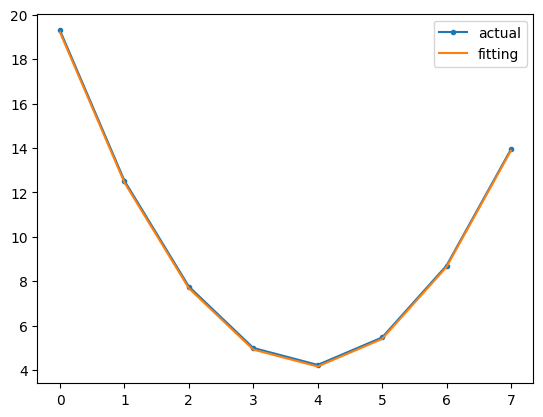

In [40]:
# Custom qwk metric and loss function for pciat_bin
# Modified from https://medium.com/@nlztrk/quadratic-weighted-kappa-qwk-metric-and-how-to-optimize-it-062cc9121baa
y = np.array([0,1,1,2,3,4,5,6,6,6,5,7,2,6,5,4,3])

a = 3.88
b = 4.15

g = np.zeros(8)
for i in range(8):
    g[i] = ((y - i)**2).mean()
    #g[i] = i

print(g)
h = [(x-a)**2 + b for x in [0,1,2,3,4,5,6,7]]
print(h)

plt.plot([0,1,2,3,4,5,6,7], g, marker=".", label="actual")
plt.plot([0,1,2,3,4,5,6,7], [(x-a)**2 + b for x in [0,1,2,3,4,5,6,7]], label="fitting")
plt.legend()
plt.show()


In [41]:
from sklearn.metrics import cohen_kappa_score

# Metric
def quadratic_weighted_kappa_bin(y_true, y_pred):
    if isinstance(y_pred, xgb.QuantileDMatrix):
        # XGB
        y_true, y_pred = y_pred, y_true

        y_true = (y_true.get_label() + a).round()
        y_pred = (y_pred + a).clip(0, 7).round()
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        return 'QWK', qwk

    else:
        # For LightGBM
        y_true = y_true + a
        y_pred = (y_pred + a).clip(0, 7).round()
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        return 'QWK', qwk, True

# Metric for both XGB and LGB
def qwk_obj_bin(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(0, 7)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess

[3.11764706 1.17647059 1.23529412 3.29411765]
[3.1109, 1.1709, 1.2309, 3.2908999999999997]


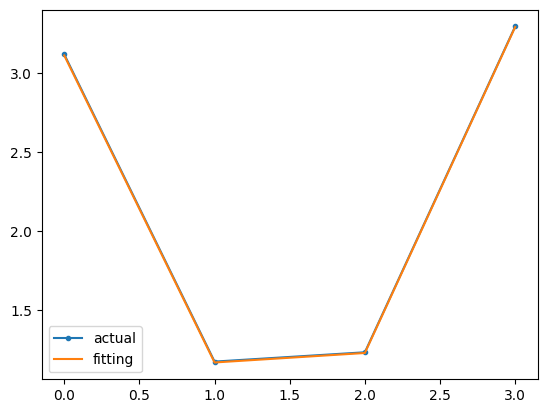

In [42]:
# Custom qwk metric and loss function for pciat_sii
#Modified from https://medium.com/@nlztrk/quadratic-weighted-kappa-qwk-metric-and-how-to-optimize-it-062cc9121baa
y = np.array([0,1,2,1,1,2,3,3,2,3,2,1,2,1,0,1,0])

c = 1.47
d = 0.95

g = np.zeros(4)
for i in range(4):
    g[i] = ((y - i)**2).mean()
    #g[i] = i

print(g)
h = [(x-c)**2 + d for x in [0,1,2,3]]
print(h)

plt.plot([0,1,2,3], g, marker=".", label="actual")
plt.plot([0,1,2,3], [(x-c)**2 + d for x in [0,1,2,3]], label="fitting")
plt.legend()
plt.show()


In [43]:
# Metric
def quadratic_weighted_kappa_sii(y_true, y_pred):
    if isinstance(y_pred, xgb.QuantileDMatrix):
        # XGB
        y_true, y_pred = y_pred, y_true

        y_true = (y_true.get_label() + c).round()
        y_pred = (y_pred + c).clip(0, 3).round()
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        return 'QWK', qwk

    else:
        # For LightGBM
        y_true = y_true + c
        y_pred = (y_pred + c).clip(0, 3).round()
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        return 'QWK', qwk, True

# Metric for both XGB and LGB
def qwk_obj_sii(y_true, y_pred):
    labels = y_true + c
    preds = y_pred + c
    preds = preds.clip(0, 3)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-c)**2+d)
    df = preds - labels
    dg = preds - c
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess

In [44]:
'''
# Custom loss that combines MSE and QWK
def combined_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Mean Squared Error
    #qwk_loss = tf.py_function(quadratic_weighted_kappa, [y_true, y_pred], tf.float64)  # QWK
    qwk_loss = qwk(y_true, y_pred)
    #qwk_loss = tf.convert_to_tensor(qwk_loss, dtype=tf.float32)
    # Add a weighting factor
    #return mse_loss
    #return (mse_loss, 10 * qwk_loss)
    return mse_loss - (50 * qwk_loss) + 100 # Subtract qwk loss as higher qwk is better. Multiplier needs to be chosen by trial and error. Added constant so loss is > 0
    #return (-1)*qwk_loss # Didn't work (no gradients provided) - seems it needs to be combined with nmse
'''
    

"\n# Custom loss that combines MSE and QWK\ndef combined_loss(y_true, y_pred):\n    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Mean Squared Error\n    #qwk_loss = tf.py_function(quadratic_weighted_kappa, [y_true, y_pred], tf.float64)  # QWK\n    qwk_loss = qwk(y_true, y_pred)\n    #qwk_loss = tf.convert_to_tensor(qwk_loss, dtype=tf.float32)\n    # Add a weighting factor\n    #return mse_loss\n    #return (mse_loss, 10 * qwk_loss)\n    return mse_loss - (50 * qwk_loss) + 100 # Subtract qwk loss as higher qwk is better. Multiplier needs to be chosen by trial and error. Added constant so loss is > 0\n    #return (-1)*qwk_loss # Didn't work (no gradients provided) - seems it needs to be combined with nmse\n"

# Models

1. First, we look for good combos of actigraph inclusion, PCA, augmentation and sample weights
2. Then, we keep those combos and look for different targets and objective functions
3. Finally, we vary XGBoost model parameters


# V1: Basic model

In [24]:
#xgb_model = XGBRegressor(random_state=42, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.7)

In [25]:
#xgb_model.fit(X_train_labelled, y_train_labelled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

**Score: 0.388, 0.377**

# V2: Using augmented data

In [35]:
'''
xgb_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'max_depth': [3, 5, 7, 9],  # Depth of each tree
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight for a node to be a leaf
    'subsample': [0.7, 0.8, 0.9, 1.0]  # Fraction of training data used for each tree
}

model = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=xgb_param_grid, 
                           scoring='neg_mean_squared_error',  # For regression tasks, use MSE or RMSE
                           cv=5,  # 5-fold cross-validation
                           verbose=1,  # Show progress
                           n_jobs=-1,  # Use all CPU cores
                           refit=True)  # Refit the model with the best parameters

grid_search.fit(X_train_labelled_aug1, y_train_labelled_aug1)

# Print best parameters and best score for XGBoost
print("Best parameters for XGBoost:", grid_search.best_params_)
print("Best CV score for XGBoost:", grid_search.best_score_)

#Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}
#Best CV score for XGBoost: -129.1881143988609
'''

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9}
Best CV score for XGBoost: -129.1881143988609


In [60]:
#xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror', learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=300, subsample=0.9)
#xgb_model = XGBRegressor(random_state=42, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.7)

In [61]:
#xgb_model.fit(X_train_labelled_aug2b, y_train_labelled_aug2b)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# V3: PCA

In [110]:
#pca = PCA(n_components=34)
#X_train_labelled_pca = pd.DataFrame(pca.fit_transform(X_train_labelled))
#X_test_fimpute_pca = pd.DataFrame(pca.transform(X_test_fimpute))

#X_train_labelled_pca.shape, X_test_fimpute_pca.shape

((2736, 34), (20, 34))

In [94]:
#xgb_model = XGBRegressor(random_state=42, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.7)

In [98]:
#xgb_model.fit(X_train_labelled_pca, y_train_labelled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

PCA didn't really seem to help in any situation - we are probably underfitting to begin with.

# V4: Sample weights

We are not going to be using PCA. We can test augmentation with 1b and 2b (and 1a and 2a, though they have been consistently worse). We have not yet dismissed including the actigraph data but we will start by not including it.

In [177]:
#xgb_model = XGBRegressor(random_state=42, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.7)

In [179]:
#xgb_model.fit(X_train_labelled_aug2a, y_train_labelled_aug2a, sample_weight=weights_labelled3_aug2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Mixed results. Linear weights were not bad for non-augmented data, and geometric weights for once-augmented data. But cannot say that any sample weight approach was an improvement on the base.

# V5: Different target data

Trying target bin and target sii, as well as different objective functions

In [45]:
#xgb_model = XGBRegressor(random_state=42, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.7)
#xgb_model = XGBRegressor(random_state=42, objective=qwk_obj_bin, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.7)
xgb_model = XGBRegressor(random_state=42, objective=qwk_obj_sii, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.7)

In [46]:
#xgb_model.fit(X_train_labelled, y_train_labelled)
#xgb_model.fit(X_train_labelled, y_train_labelled_bin)
xgb_model.fit(X_train_labelled, y_train_labelled_sii)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None,
             objective=<function qwk_obj_bin at 0x7a12261c2e60>, ...)

Big improvement when using QWK as the objective function on the sii target: **0.420, 0.426** on the basic parameters. Did not get the same results from using QWK on the binned target or sii with NMSE. We cannot use QWK on the PCIAT-PCIAT_Total target, because we will have to bin them anyway, and the bins we used for the PCIAT_bin were already the most easily translatable to the final sii predictions (2:1). So going forward, we will use this objective + target when testing params.

# Final prediction with model

In [47]:
y_test = test_data[['id']]

In [49]:
#y_test['PCIAT-PCIAT_Total_xgb'] = xgb_model.predict(X_test_fimpute)
#y_test['PCIAT-PCIAT_Total_xgb'] = xgb_model.predict(X_test_fimpute_pca)
y_test['PCIAT-PCIAT_Total_xgb'] = np.round(xgb_model.predict(X_test_fimpute))
y_test.head()

<ipython-input-49-b7ee60d2a15d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['PCIAT-PCIAT_Total_xgb'] = np.round(xgb_model.predict(X_test_fimpute))


,id,PCIAT-PCIAT_Total_xgb
0,00008ff9,2.0
1,000fd460,1.0
2,00105258,2.0
3,00115b9f,1.0
4,0016bb22,2.0


In [50]:
y_test['PCIAT-PCIAT_Total'] = y_test.apply(
    lambda row: (row['PCIAT-PCIAT_Total_xgb']),
axis=1)

# Target PCIAT-PCIAT_Total
#y_test['sii'] = y_test.apply(lambda row: 0 if row['PCIAT-PCIAT_Total']<=30 else 
#                             (1 if row['PCIAT-PCIAT_Total']<50 else (
#                                2 if row['PCIAT-PCIAT_Total']<80 else (3)
#                            )), axis=1)

# Target bin
#y_test['sii'] = y_test.apply(lambda row: 0 if row['PCIAT-PCIAT_Total']<2 else 
#                             (1 if row['PCIAT-PCIAT_Total']<4 else (
#                                2 if row['PCIAT-PCIAT_Total']<6 else (3)
#                            )), axis=1)

# Target sii
y_test['sii'] = y_test['PCIAT-PCIAT_Total_xgb']

y_test.head()

<ipython-input-50-0a0ffefd052f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['PCIAT-PCIAT_Total'] = y_test.apply(
<ipython-input-50-0a0ffefd052f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['sii'] = y_test.apply(lambda row: 0 if row['PCIAT-PCIAT_Total']<2 else


,id,PCIAT-PCIAT_Total_xgb,PCIAT-PCIAT_Total,sii
0,00008ff9,2.0,2.0,1
1,000fd460,1.0,1.0,0
2,00105258,2.0,2.0,1
3,00115b9f,1.0,1.0,0
4,0016bb22,2.0,2.0,1


In [51]:
solution = y_test[['id','sii']]
solution.to_csv("submission.csv", index=False)